In [632]:
# load whatever packages you prefer here. We've added a reference list here
import numpy as np
import scipy as scipy
from scipy import linalg
import matplotlib.pyplot as plt

In [633]:
# Define the state-space model
dt = 0.1  # Time step
omega = 1.0  # Natural frequency
A_euler = np.array([[0, dt], [-omega**2 * dt, 0]])  # State transition matrix using forward Euler
A = scipy.linalg.expm(A_euler)
H = np.array([[1, 0]])  # Measurement matrix
Q = np.eye(2) * 0.005 * dt  # Process noise covariance
R = np.eye(1) * 0.5  # Measurement noise covariance

# Initialize state estimate and covariance
x_est = np.array([[1], [0]])  # Initial position and velocity
P = np.eye(2) * 1.0  # Initial uncertainty

# Simulate noisy measurements
periods = 6
time_steps = round(periods*2*np.pi/dt)
true_states = []
measurements = []
for _ in range(time_steps):
    x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
    measurement = H @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
    true_states.append(x_est.flatten())
    measurements.append(measurement.flatten())

In [634]:
# Implement the Kalman Filter
filtered_states = []
for z in measurements:
    # Prediction Step
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q
    
    # Compute Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    
    # Update Step
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(2) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

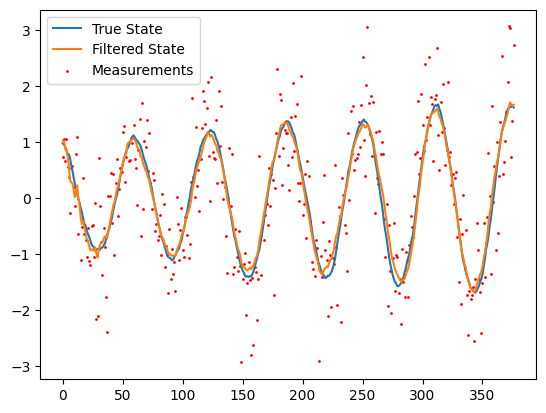

In [635]:
# Plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in filtered_states], label='Filtered State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=1)
plt.legend()
plt.show()

In [636]:
#helper functions and generation of states

# euclidean norm
def s(m):
    return np.sqrt(np.sum(m**2))

#c is normal with mean 0 and variance s(m) x sigma_y^2

def measure(x, m, sigma_y):
    s_m = s(m)
    
    c = np.random.normal(0, s_m * sigma_y^2)  
    measurement_y = m.T @ x + c
    return measurement_y

def compute_eigenvector(A):
    # Compute the eigen decomposition of the matrix A
    eigvals, eigvecs = np.linalg.eig(A)
    # Find the index of the largest eigenvalue
    idx = np.argmax(eigvals)
    # Return the largest eigenvalue and the corresponding unit eigenvector
    return eigvals[idx], eigvecs[:,idx]


#find principal component of the covariance matrix
def select_measurement_direction(P):
    # Compute the largest eigenvector of the covariance matrix
    eigenvalue, eigenvector = compute_eigenvector(P)
    return eigenvector / np.linalg.norm(eigenvector)


def kalman_update(x, P, y, sigma2):
    # Select optimal measurement direction based on current uncertainty
    m = select_measurement_direction(P)
    
    # Compute innovation: difference between observed measurement and predicted measurement
    innovation = y - np.dot(m.T, x)
    
    # innovation variance
    S = np.dot(m.T, np.dot(P, m)) + sigma2
    
    # Kalman Gain.
    K = np.dot(P, m) / S
    
    # updating state estimate
    x_new = x + K * innovation
    
    # Update covariance matrix
    P_new = P - np.outer(K, np.dot(m.T, P))
    
    return x_new, P_new, m


In [ ]:



# Update the iterate_kalman function to work with your measurements from cell 2
def iterate_kalman(x_init, P_init, measurements, A, Q, sigma2, time_steps):
    states = []
    states.append(x_init.flatten())  # Store initial state
    
    x = x_init.copy()
    P = P_init.copy()
    
    for measurement in measurements:
        # 1. Prediction step - Apply system dynamics from cell 2
        x = A @ x  # State prediction
        P = A @ P @ A.T + Q  # Covariance prediction with process noise
        
        # 2. Update step with actual measurement
        y = measurement  # Extract scalar measurement from the array
        x, P, m = kalman_update(x, P, y, sigma2)
        
        # Store the state
        states.append(x.flatten())
    
    return states

# Simulate noisy measurements
periods = 6
time_steps = round(periods*2*np.pi/dt)
true_states = []
measurements = []
# Run the Kalman filter
x_init = np.array([[1], [0]])  # Initial state estimate
P_init = np.eye(2) * 1.0  # Initial covariance estimate
A = scipy.linalg.expm(A_euler)  # State transition matrix
Q = np.eye(2) * 0.005 * dt  # Process noise covariance
sigma2 = 0.5  # Measurement noise variance

#generate the true states and measurements
for _ in range(time_steps):
    x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
    measurement = select_measurement_direction(P) @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
    true_states.append(x_est.flatten())
    measurements.append(measurement.flatten())



filtered_states = iterate_kalman(x_init, P_init, measurements, A, Q, sigma2, time_steps)



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

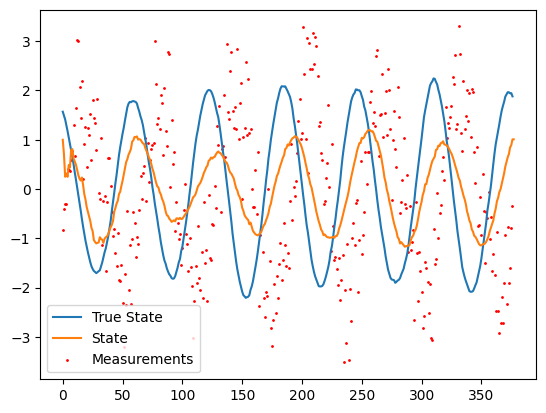

In [638]:
# plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in States2], label='State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=1)
plt.legend()
plt.show()

In [639]:
#Lorenz case
from scipy.integrate import solve_ivp

# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
dt = 0.02  # Time step - default 0.02

# Define the Lorenz system
def lorenz_system(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Solve Lorenz system numerically
t_end = 20
time_span = np.linspace(0, t_end, round(t_end/dt))
sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], [1, 1, 1], t_eval=time_span)

# Observation matrix (assume we only observe x and y)
H = np.array([[1, 0, 0], [0, 1, 0]])
Q = np.eye(3) * 0.0 * dt  # Process noise covariance - Set very small since we solved the dynamic exactly above. Any noise here models integration error in the ODE solver
R = np.eye(2) * 0.2  # Measurement noise covariance - default 0.2

# Initial state and covariance
x_est = np.array([[1], [1], [1]])
P = np.eye(3) * 1.0

# Generate noisy observations
measurements = sol.y[:2].T + np.random.normal(0, 1, (len(time_span), 2)) @ scipy.linalg.sqrtm(R).T

In [640]:
# Kalman filter implementation
filtered_states = []
for z in measurements:
    J = np.array([[-sigma, sigma, 0], 
                  [rho, -1, -x_est[0]], 
                  [x_est[1], x_est[0], -beta]],
                dtype=object)  # Jacobian of the Lorenz dynamic
    A = scipy.linalg.expm(J * dt) # state transition matrix for linear approximation to the dynamic
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_est = x_pred + K @ (z.reshape(-1, 1) - H @ x_pred)
    P = (np.eye(3) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

filtered_states = np.array(filtered_states)

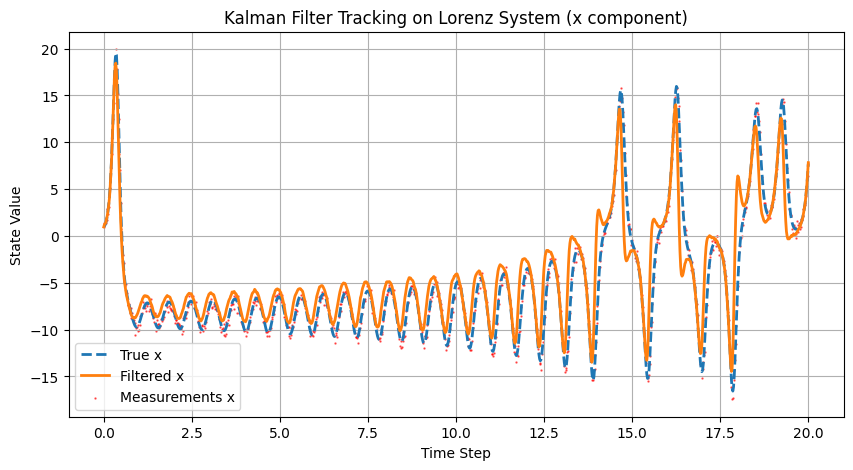

In [641]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(time_span, sol.y[0], label='True x', linestyle='dashed', linewidth=2)
plt.plot(time_span, filtered_states[:, 0], label='Filtered x', linewidth=2)
plt.scatter(time_span, measurements[:, 0], label='Measurements x', color='red', s=0.5, alpha=0.6)
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Kalman Filter Tracking on Lorenz System (x component)')
plt.legend()
plt.grid(True)
plt.show()

In [642]:

def compute_eigenvector_lorentz(A):
    # Compute the eigen decomposition of the matrix A
    eigvals, eigvecs = np.linalg.eig(A)
    # Find the index of the largest eigenvalue
    idx = np.argmax(eigvals)
    # Return the largest eigenvalue and the corresponding unit eigenvector
    return eigvals[idx], eigvecs[:,idx]

def select_measurement_direction_lorentz(P):
    # Compute the largest eigenvector of the covariance matrix
    eigenvalue, eigenvector = compute_eigenvector_lorentz(P)
    return eigenvector / np.linalg.norm(eigenvector)

In [643]:

def lorenz_jacobian(x_est, sigma=10, rho=28, beta=8/3):
    """Compute the Jacobian matrix for the Lorenz system at state x"""
    # Extract state variables as float values
    x1 = x_est[0]
    x2 = x_est[1]
    x3 = x_est[2]
    
    # Construct Jacobian with proper float dtype
    J = np.array([
        [-sigma, sigma, 0], 
        [rho - x3, -1, -x1],
        [x2, x1, -beta]
    ], dtype=float)
    
    return J


def kalman_update_lorenz(x, P, y, sigma2):
    """
    Perform the Kalman update step with adaptive measurement direction.
    
    Args:
        x: State estimate (3x1 vector)
        P: State covariance matrix (3x3 matrix)
        y: Scalar measurement value
        sigma2: Measurement noise variance (scalar)
    
    Returns:
        x_new: Updated state estimate
        P_new: Updated state covariance matrix
    """
    # Get adaptive measurement direction
    m = select_measurement_direction_lorentz(P)
    
    # Compute predicted measurement (scalar)
    y_pred = m.T @ x
    
    # Compute innovation (difference between observed and predicted measurement)
    innovation = y - y_pred
    
    # Innovation variance (scalar)
    S = (m.T @ (P @ m)) + sigma2
    
    # Kalman Gain (vector)
    K = (P @ m) / S
    
    # Update state estimate
    x_new = x + K * innovation
    
    # Update covariance matrix using outer product
    P_new = P - np.outer(K, m.T @ P)
    
    # Add small regularization to prevent numerical issues
    P_new = P_new + np.eye(3) * 1e-8
    
    return x_new, P_new

def iterate_kalman_lorenz(x_init, P_init, measurements, Q, sigma2, dt):
    states = []
    x_init = x_init.reshape(-1, 1)  # Ensure column vector
    states.append(x_init.flatten())
    
    x = x_init.copy()
    P = P_init.copy()
    
    for measurement in enumerate(measurements):
        # 1. Prediction step
        J = lorenz_jacobian(x.flatten())
        A = scipy.linalg.expm(J * dt)
        x_pred = A @ x
        P_pred = A @ P @ A.T + Q
        
        # 2. Get scalar measurement by projecting onto optimal direction
        m = select_measurement_direction_lorentz(P_pred)
        
        # Project 2D measurement onto our adaptive direction
        # We'll use just the x-component (first component) as our scalar observation
        # (In a real adaptive system, you'd project your measurement onto the chosen direction)
        y_scalar = measurement # Just use the first component for simplicity
        
        # 3. Update step with scalar measurement
        x, P = kalman_update_lorenz(x_pred, P_pred, y_scalar, sigma2)
        
        # Store the state
        states.append(x.flatten())
    
    return states

#Make new values for the Lorenz system
# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
dt = 0.02  # Time step
Q = np.eye(3) * 0.005 # Process noise covariance
R = np.eye(1) * 0.05  # Measurement noise covariance
dt = 0.1  # Time step


# Call with scalar measurement noise
x_init = np.array([[1], [1], [1]])  # 3D initial state for Lorenz as column vector
P_init = np.eye(3) * 1.0  # Initial covariance
sigma2 = R[0, 0]  # Use the first diagonal element of R as scalar noise variance

# Run the Kalman filter
states3 = iterate_kalman_lorenz(x_init, P_init, measurements, Q, sigma2, dt)
states3 = np.array(states3[1:])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

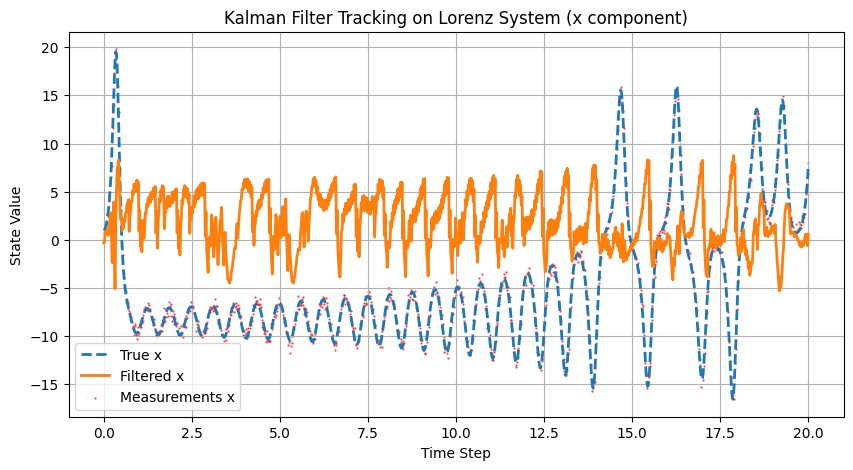

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(time_span, sol.y[0], label='True x', linestyle='dashed', linewidth=2)
plt.plot(time_span, np.array([state[0] for state in states3]), label='Filtered x', linewidth=2)
plt.scatter(time_span, measurements[:, 0], label='Measurements x', color='red', s=0.5, alpha=0.6)
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Kalman Filter Tracking on Lorenz System (x component)')
plt.legend()
plt.grid(True)
plt.show()


